In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%load_ext watermark

# Multi-Factor Models

## Implementing the CAPM in Python

### How to do it...

1. Import the required libraries:

In [4]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

In [5]:
%watermark --iversions

yfinance    0.1.42
pandas      0.24.2
statsmodels 0.9.0
json        2.0.9
numpy       1.16.2
autopep8    1.4.4
matplotlib  3.0.3



2. Specify the risky asset and the time horizon:

In [6]:
risky_asset = 'AMZN'
market_benchmark = '^GSPC'
start_date = '2014-01-01'
end_date = '2018-12-31'

3. Download data from Yahoo Finance:

In [7]:
df = yf.download([risky_asset, market_benchmark],
                 start=start_date,
                 end=end_date,
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


4. Resample to monthly data and calculate simple returns:

In [8]:
X = df['Adj Close'].rename(columns={risky_asset: 'asset', market_benchmark: 'market'}) \
                   .resample('M') \
                   .last() \
                   .pct_change() \
                   .dropna()
X.head()

,asset,market
Date,,
2014-01-31,-0.100554,-0.035583
2014-02-28,0.009507,0.043117
2014-03-31,-0.071058,0.006932
2014-04-30,-0.095847,0.006201
2014-05-31,0.027686,0.021030


5. Calculate beta using the covariance approach: 

In [9]:
covariance = X.cov().iloc[0,1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance
beta

1.6709212115173373

6. Prepare the input and estimate CAPM as a linear regression:

In [10]:
# separate target
y = X.pop('asset')

# add constant
X = sm.add_constant(X)

# define and fit the regression model 
capm_model = sm.OLS(y, X).fit()

# print results 
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     35.63
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           1.53e-07
Time:                        23:11:41   Log-Likelihood:                 76.708
No. Observations:                  60   AIC:                            -149.4
Df Residuals:                      58   BIC:                            -145.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.009      1.842      0.0

### There's more...

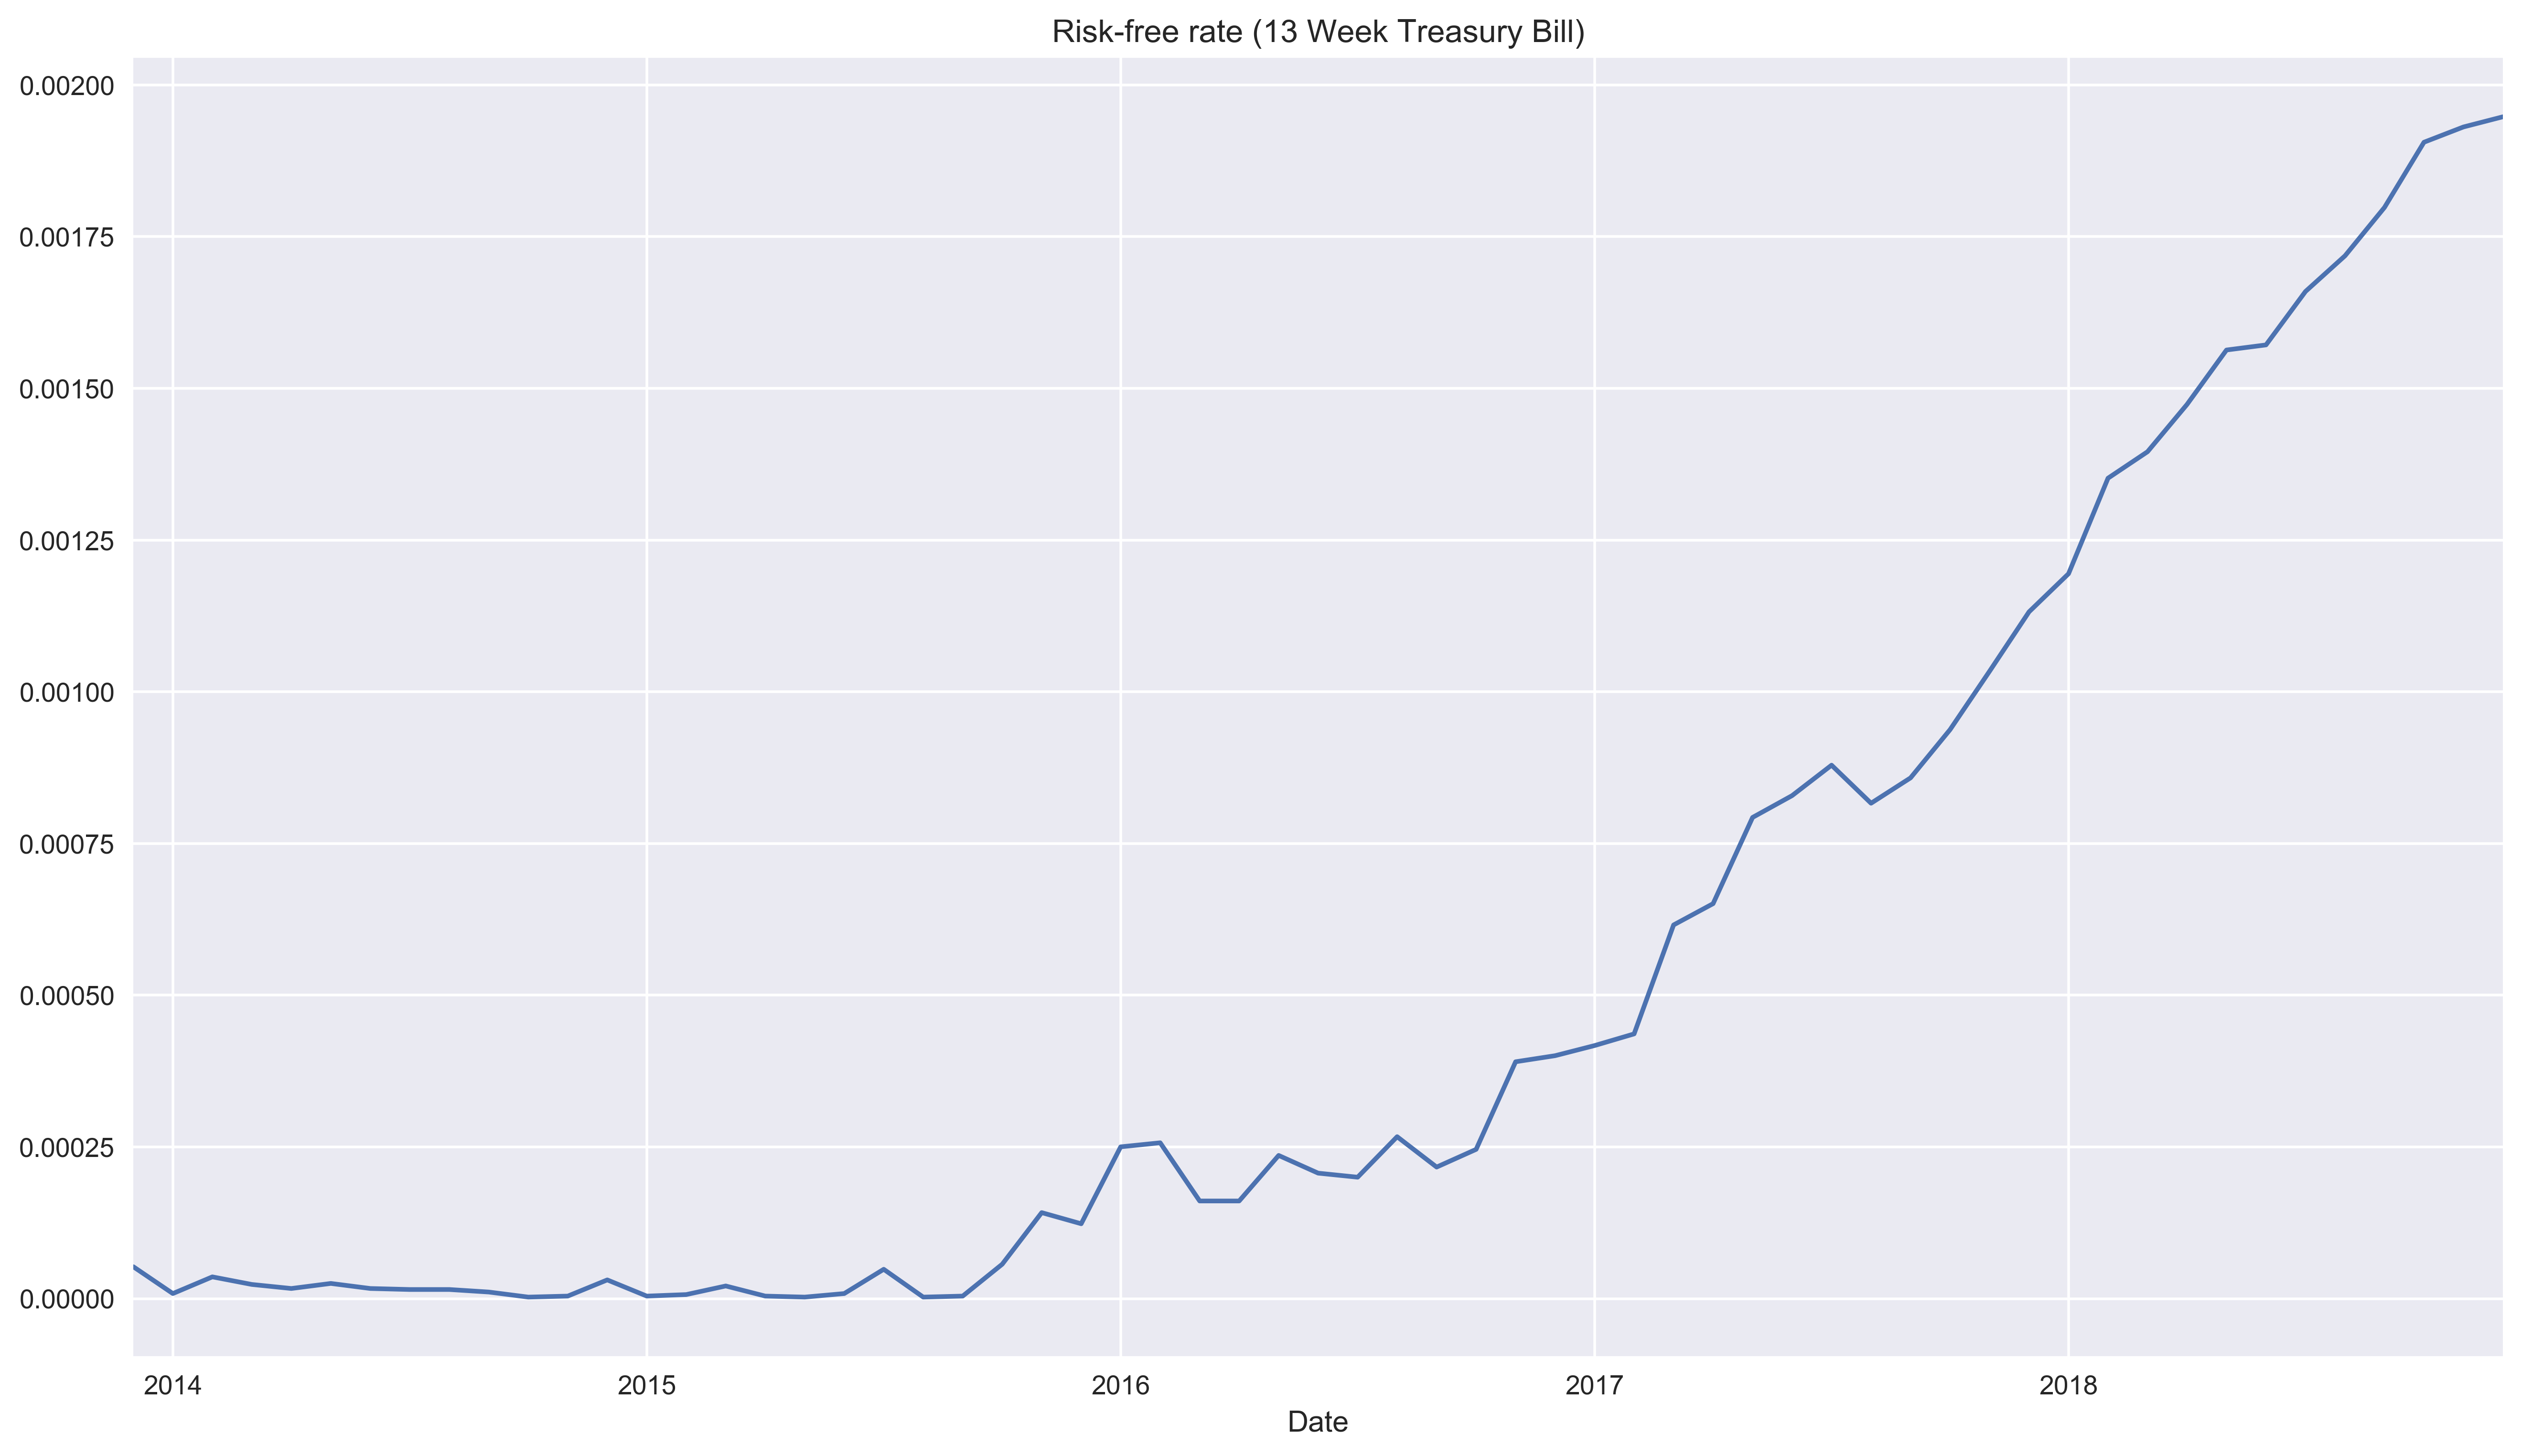

In [24]:
# period lenght in days
n_days = 90

# download data from Yahoo finance
df_rf = yf.download('^IRX',
                    start=start_date,
                    end=end_date,
                    progress=False)

# resample to monthly by taking last value from each month
rf = df_rf.resample('M').last().Close / 100

# calculate the corresponding daily risk-free return  
rf = ( 1 / (1 - rf * n_days/360) )**(1/n_days)  

# convert to monthly and subtract 1
rf = (rf ** 30) - 1 

# plot the risk-free rate
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

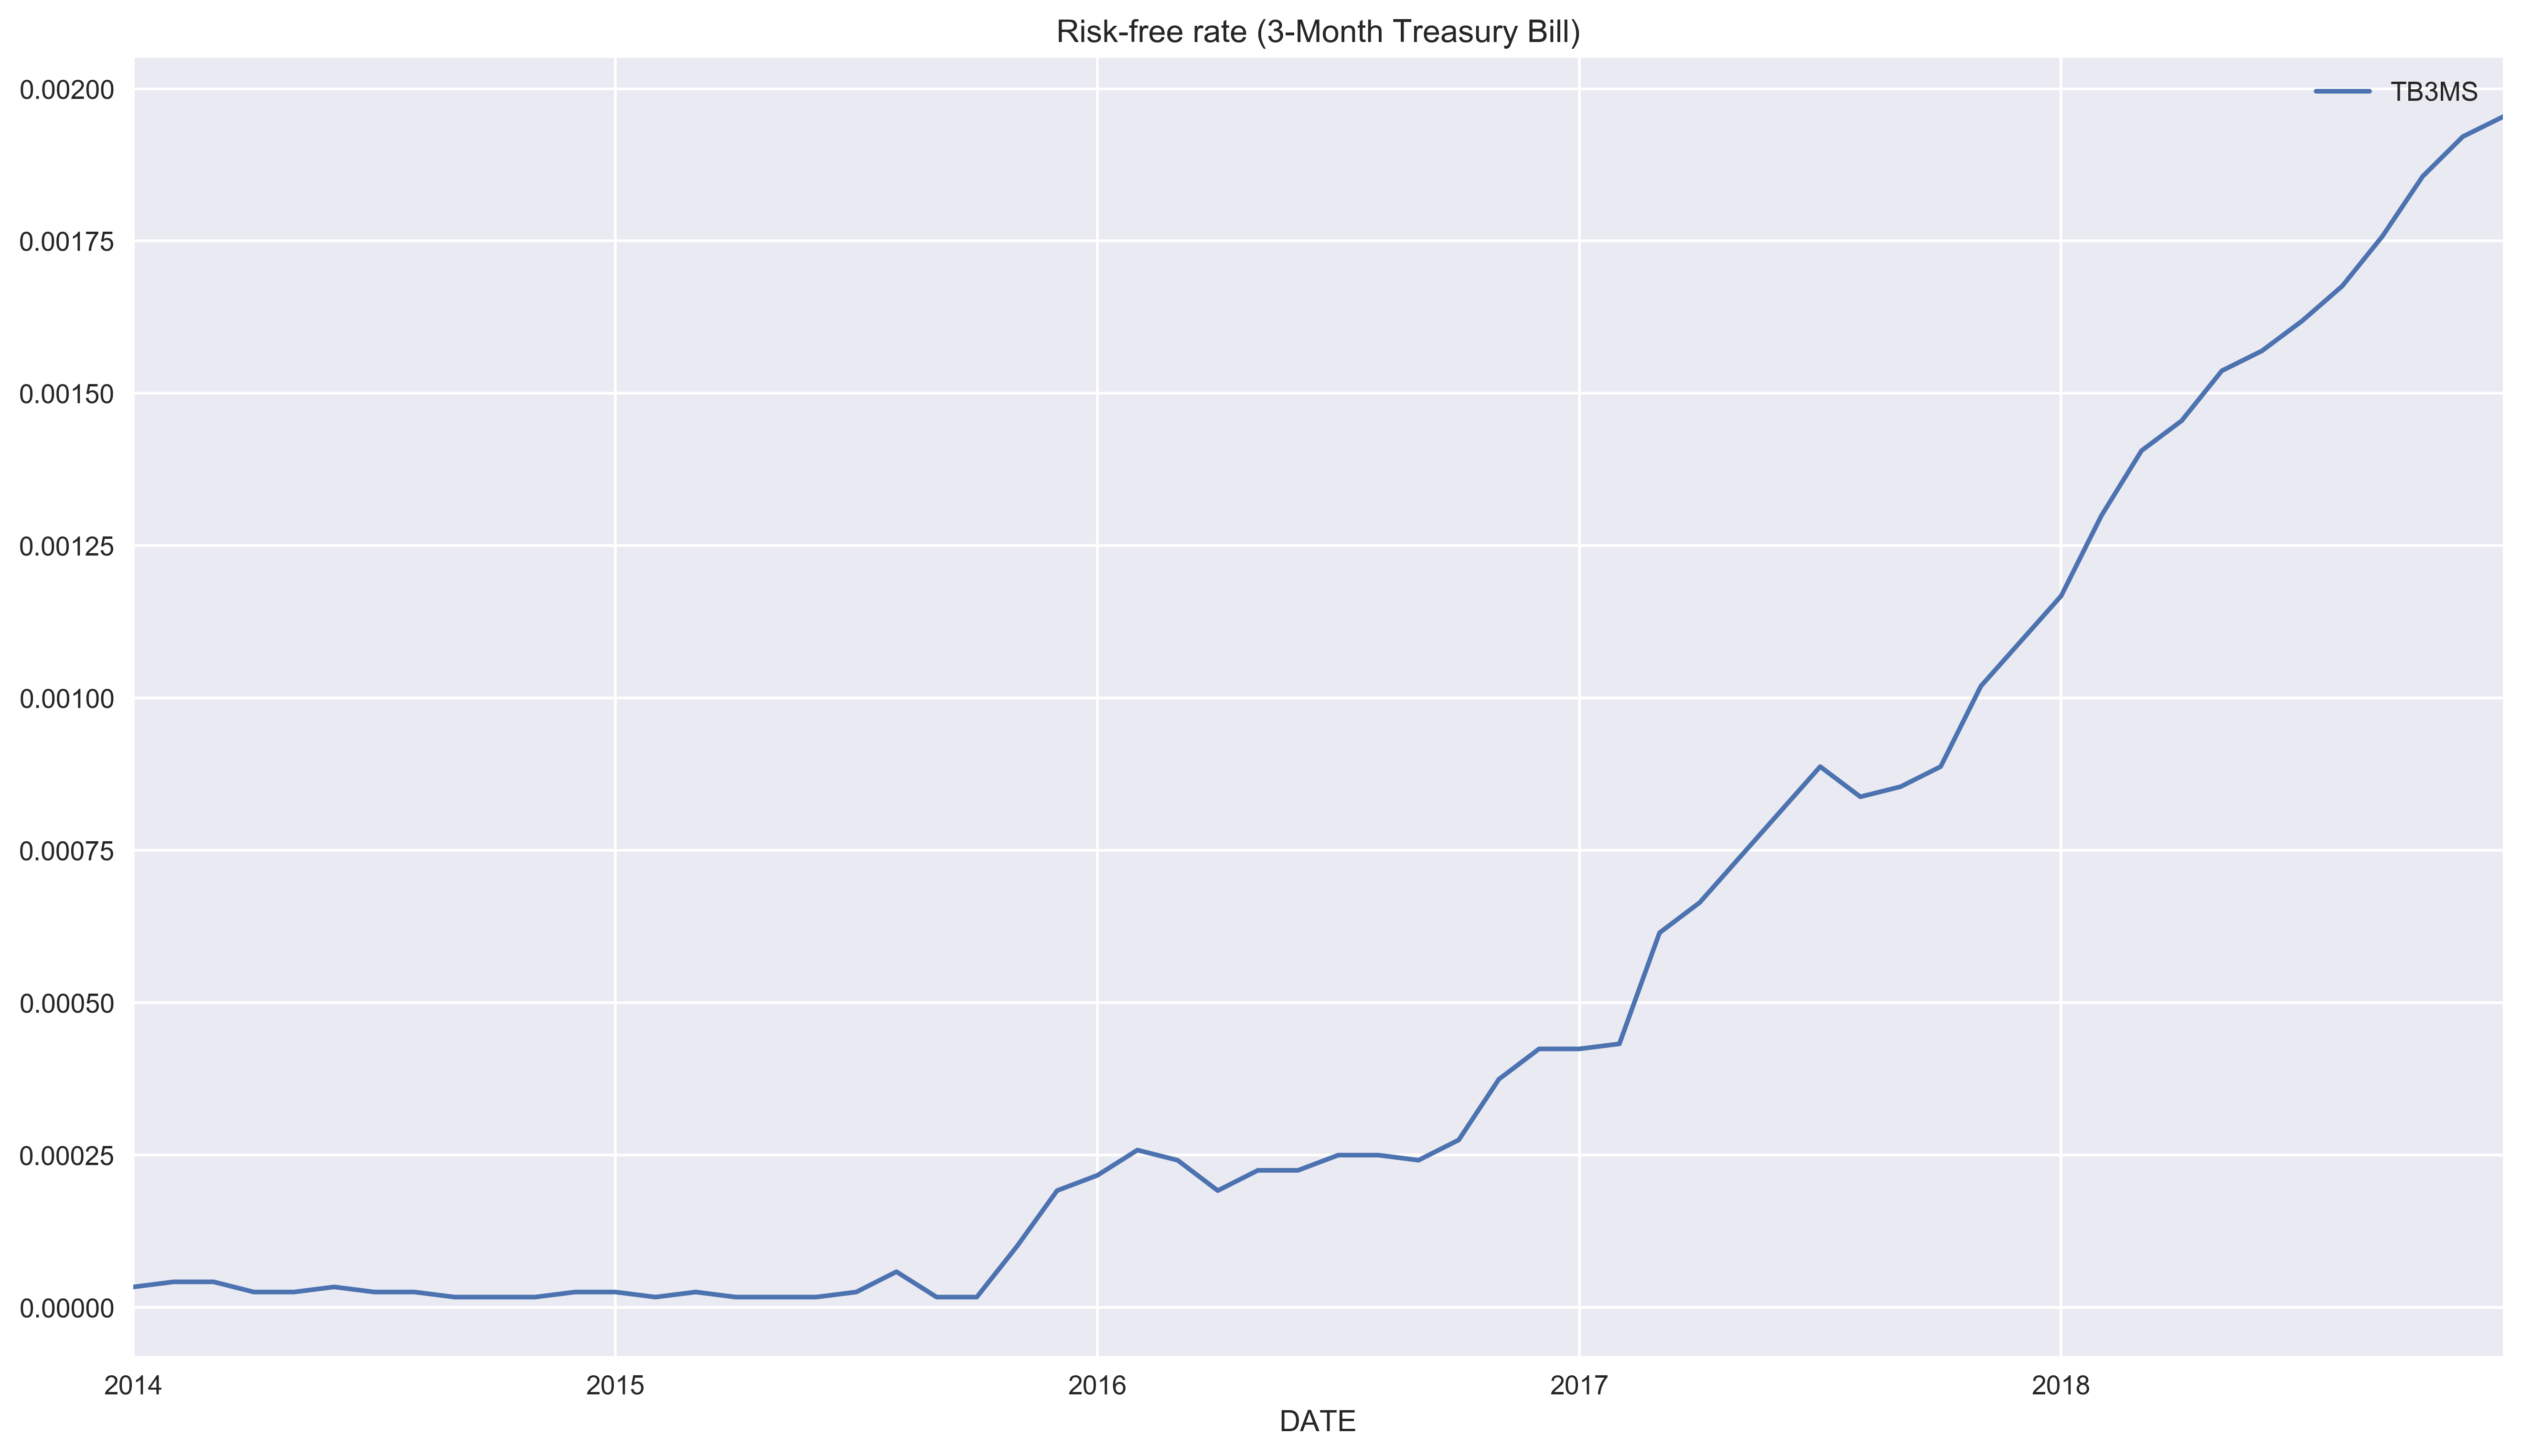

In [25]:
import pandas_datareader.data as web

# download the data 
rf = web.DataReader('TB3MS', 'fred', start=start_date, end=end_date)

# convert to monthly
rf = (1 + (rf / 100))**(1 / 12) - 1

# plot the risk-free rate
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

## Implementing the Fama-French three-factor model in Python

### How to do it...

1. Import the required libraries:

In [4]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

In [5]:
%watermark --iversions

yfinance    0.1.42
statsmodels 0.9.0
numpy       1.16.2
matplotlib  3.0.3
json        2.0.9
autopep8    1.4.4
pandas      0.24.2



2. Download data from prof. French's website:

In [6]:
# download the zip file from Prof. French's website
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# unpack the zip
!unzip -a F-F_Research_Data_Factors_CSV.zip

# remove the zip
!rm F-F_Research_Data_Factors_CSV.zip

--2019-08-01 16:39:19--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.181.201
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.181.201|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12288 (12K) [application/x-zip-compressed]
Saving to: ‘F-F_Research_Data_Factors_CSV.zip’

F-F_Research_Data_F 100%[===================>]  12.00K  --.-KB/s    in 0s      

2019-08-01 16:39:19 (36.9 MB/s) - ‘F-F_Research_Data_Factors_CSV.zip’ saved [12288/12288]

Archive:  F-F_Research_Data_Factors_CSV.zip
replace F-F_Research_Data_Factors.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


3. Define parameters:

In [8]:
risky_asset = 'FB'
start_date = '2013-12-31'
end_date = '2018-12-31'

4. Clean data from the source CSV:

In [9]:
# load data from csv
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)
# identify where the annual data starts
start_of_annual = factor_df[factor_df.iloc[:, 0] == ' Annual Factors: January-December '].index[0]
# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']
# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], format='%Y%m').dt.strftime("%Y-%m")
# set index
factor_df = factor_df.set_index('date')
# filter only required dates
factor_df = factor_df.loc[start_date:end_date]
# convert all columns to numeric
cols = factor_df.columns
factor_df[cols] = factor_df[cols].apply(pd.to_numeric, errors='coerce')
# devide all values by 100, as they are stated in percentages
factor_df = factor_df.div(100)

factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0086,-0.0209,0.0
2014-02,0.0465,0.0032,-0.0040,0.0
2014-03,0.0043,-0.0189,0.0508,0.0
2014-04,-0.0019,-0.0425,0.0114,0.0
2014-05,0.0206,-0.0185,-0.0027,0.0


5. Download the prices of the risky asset:

In [10]:
asset_df = yf.download(risky_asset,
                       start=start_date,
                       end=end_date,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


6. Calculate monthly returns on the risky asset:

In [12]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

7. Merge the datasets:

In [13]:
# merge datasets
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

8. Estimate the three-factor model:

In [14]:
# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     5.153
Date:                Thu, 01 Aug 2019   Prob (F-statistic):            0.00323
Time:                        17:04:59   Log-Likelihood:                 88.365
No. Observations:                  60   AIC:                            -168.7
Df Residuals:                      56   BIC:                            -160.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0105      0.008      1.370      0.1

### There's more...

1. Import libraries:

In [5]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

2. Print available datasets (here only first 5):

In [6]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

3. Download the selected dataset:

In [7]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench')

In [8]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

4. Inspect the description of the dataset

In [9]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 201906 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2019 Kenneth R. French

  0 : (114 rows x 4 cols)
  1 : Annual Factors: January-December (9 rows x 4 cols)


5. View the monthly dataset:

In [11]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2010-01,-3.36,0.38,0.31,0.00
2010-02,3.40,1.21,3.17,0.00
2010-03,6.31,1.43,2.10,0.01
2010-04,2.00,4.98,2.81,0.01
2010-05,-7.89,0.05,-2.38,0.01


## Implementing the rolling three-factor model on a portfolio of assets

### How to do it...

1. Import the required libraries:

In [4]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [5]:
%watermark --iversions

pandas_datareader 0.7.0
json              2.0.9
pandas            0.24.2
statsmodels       0.9.0
yfinance          0.1.42
matplotlib        3.0.3
numpy             1.16.2
autopep8          1.4.4



2. Download the factor related data from prof. French's website:

In [9]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench')[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

3. Define the parameters:

In [13]:
assets = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
weights = [0.25, 0.25, 0.25, 0.25]
start_date = '2009-12-31'
end_date = '2018-12-31'

4. Download the data of the risky assets from Yahoo Finance:

In [15]:
asset_df = yf.download(assets,
                       start=start_date,
                       end=end_date,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2265 rows of data.


5. Calculate monthly returns on the risky assets:

In [16]:
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

6. Calculate portfolio returns:

In [17]:
asset_df['portfolio_returns'] = np.matmul(asset_df[assets].values, weights)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
2010-01,-0.088358,-0.067722,-0.145226,-0.075362,-0.094167
2010-02,0.065308,-0.055897,-0.005910,0.021944,0.006361
2010-03,0.148380,0.146706,0.076519,0.021911,0.098379
2010-04,0.110847,0.009796,-0.073027,0.042453,0.022517
2010-05,-0.015917,-0.084902,-0.076221,-0.151378,-0.082104


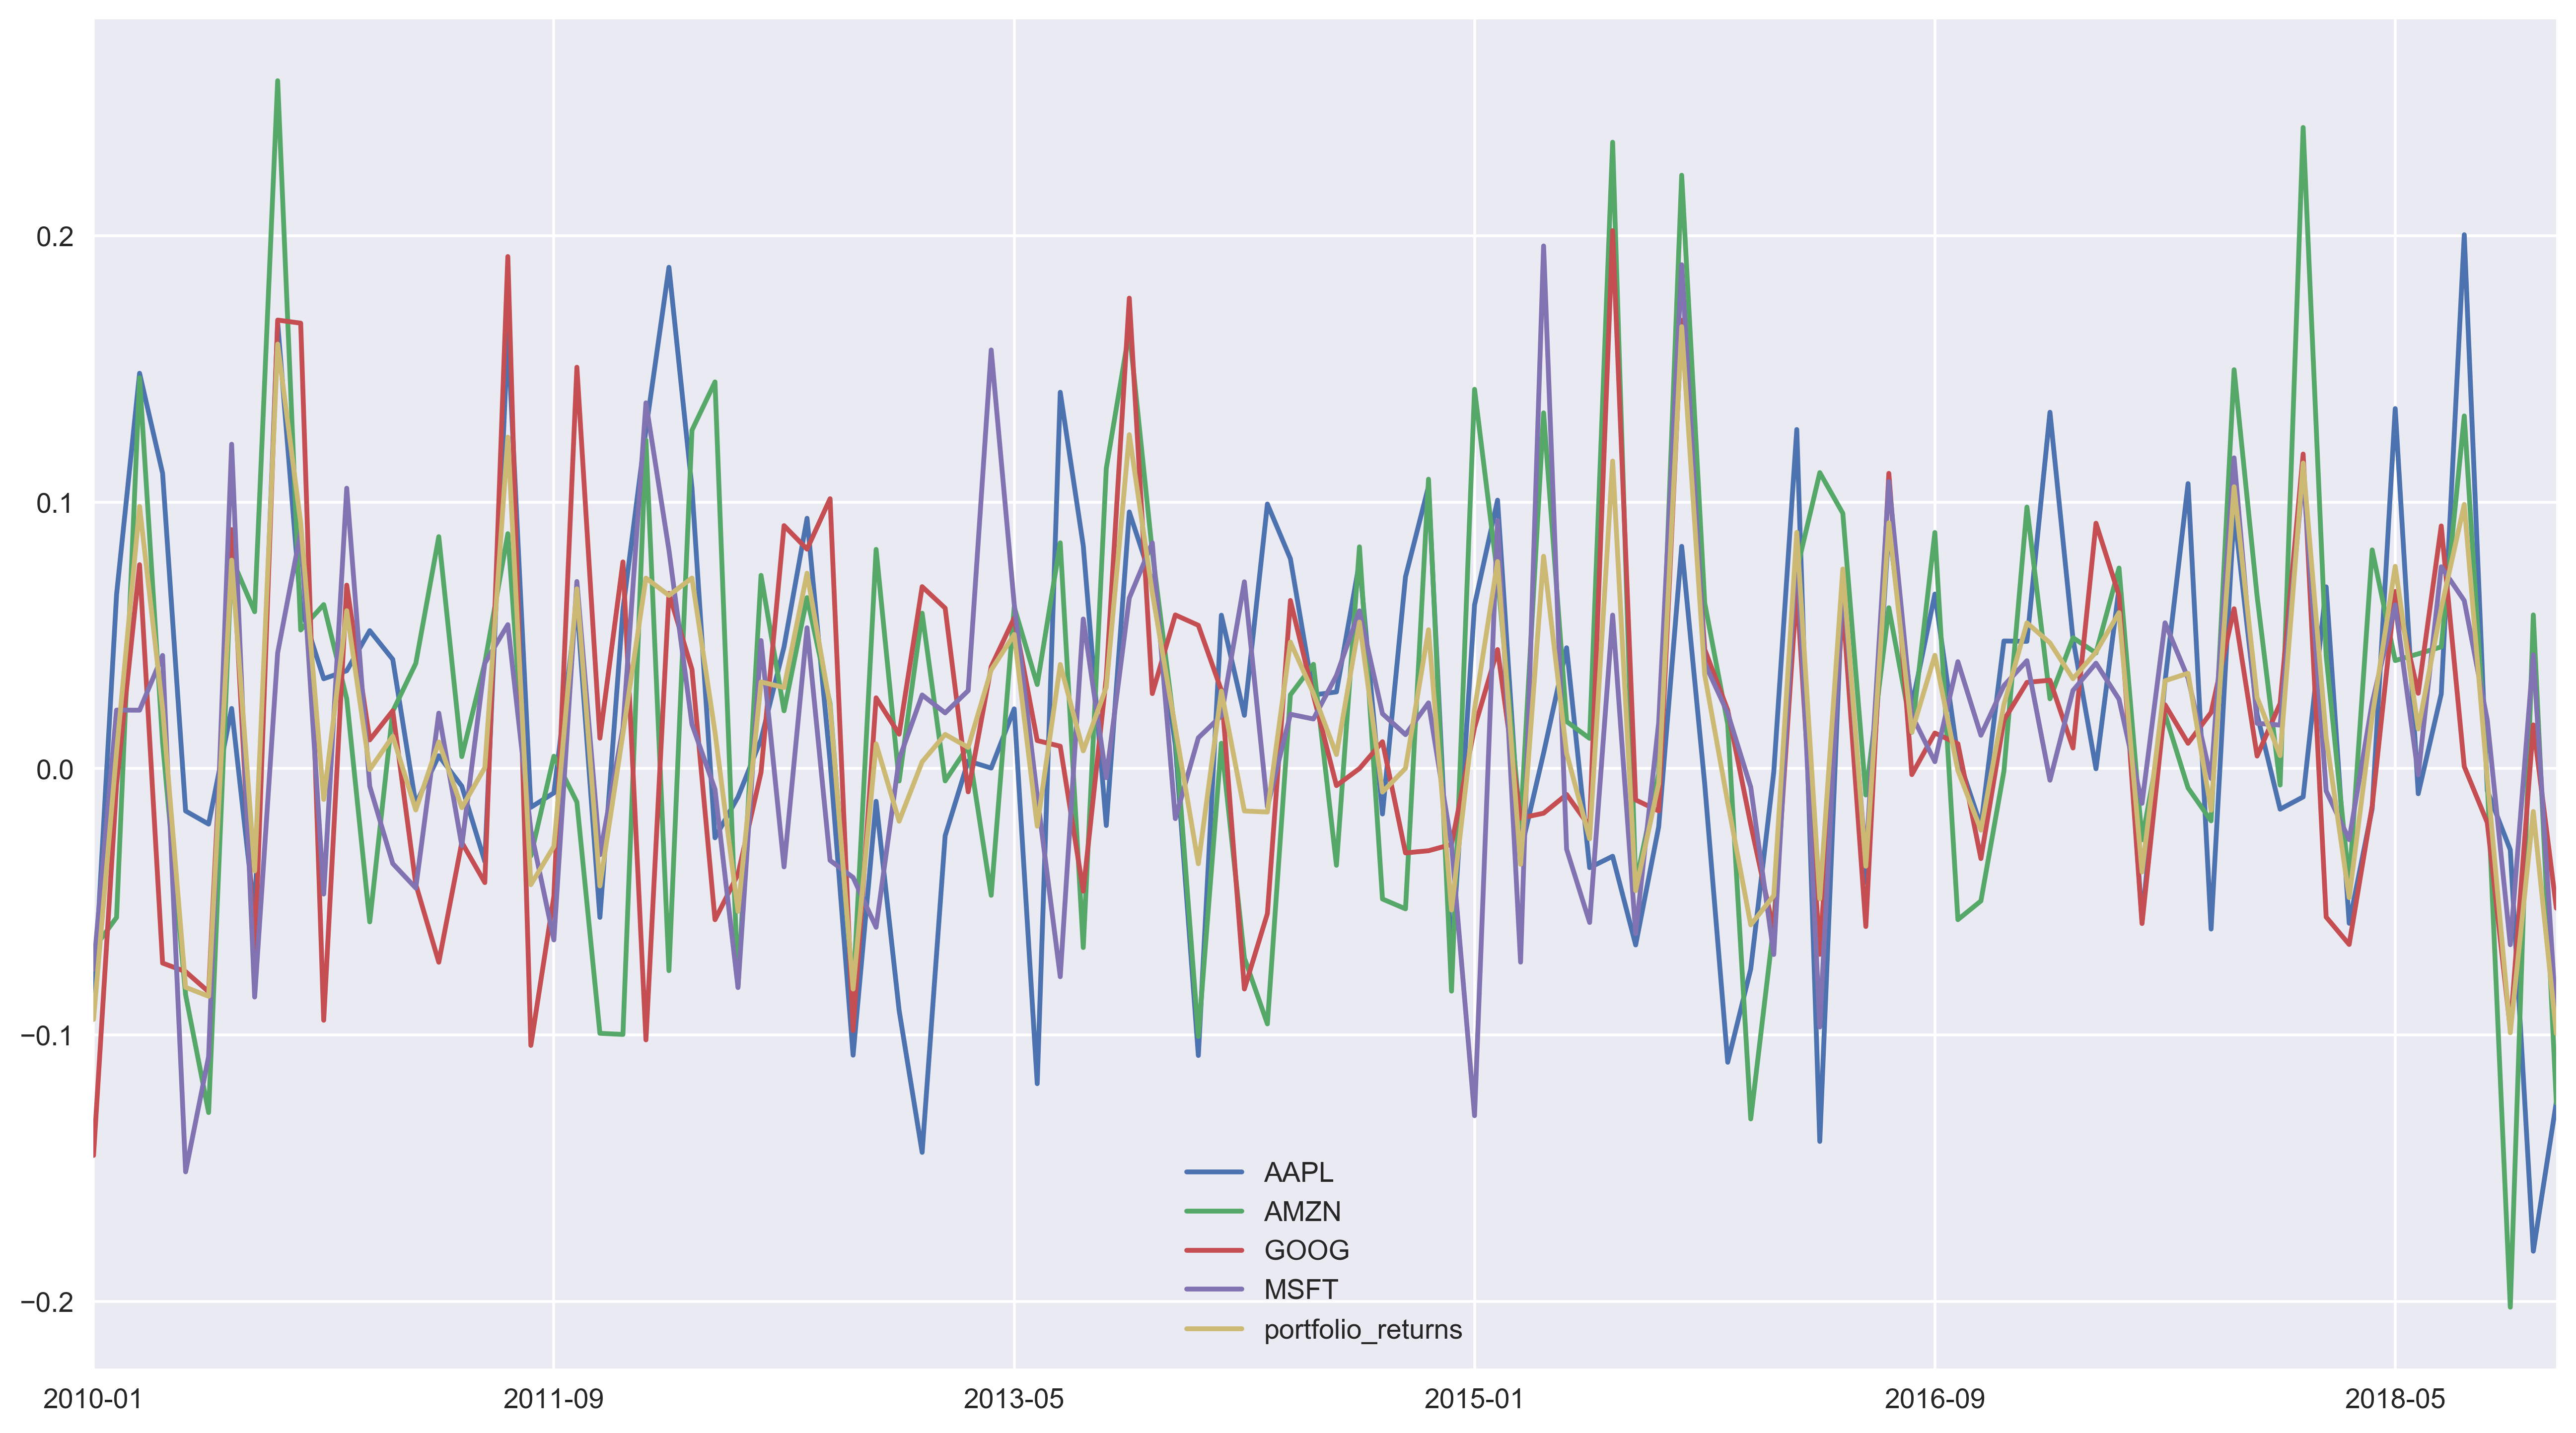

In [18]:
# inspect the returns 
asset_df.plot()

7. Merge the datasets:

In [26]:
ff_data = asset_df.join(df_three_factor).drop(assets, axis=1)
ff_data.columns = ['portfolio_returns', 'mkt', 'smb', 'hml', 'rf']
ff_data['portfolio_excess'] = ff_data.portfolio_returns - ff_data.rf

In [20]:
ff_data.head()

,portfolio_returns,market_premium,smb,hml,rf,portfolio_excess
2010-01,-0.094167,-0.0336,0.0038,0.0031,0.0000,-0.094167
2010-02,0.006361,0.0340,0.0121,0.0317,0.0000,0.006361
2010-03,0.098379,0.0631,0.0143,0.0210,0.0001,0.098279
2010-04,0.022517,0.0200,0.0498,0.0281,0.0001,0.022417
2010-05,-0.082104,-0.0789,0.0005,-0.0238,0.0001,-0.082204


8. Define a function for the rolling n-factor model

In [28]:
def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data)-window_size+1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(formula=formula, 
                           data=input_data[start_index:end_index]).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(coeffs, index=input_data.index[window_size-1:])

    return coeffs_df

9. Estimate the rolling three-factor model and plot the results:

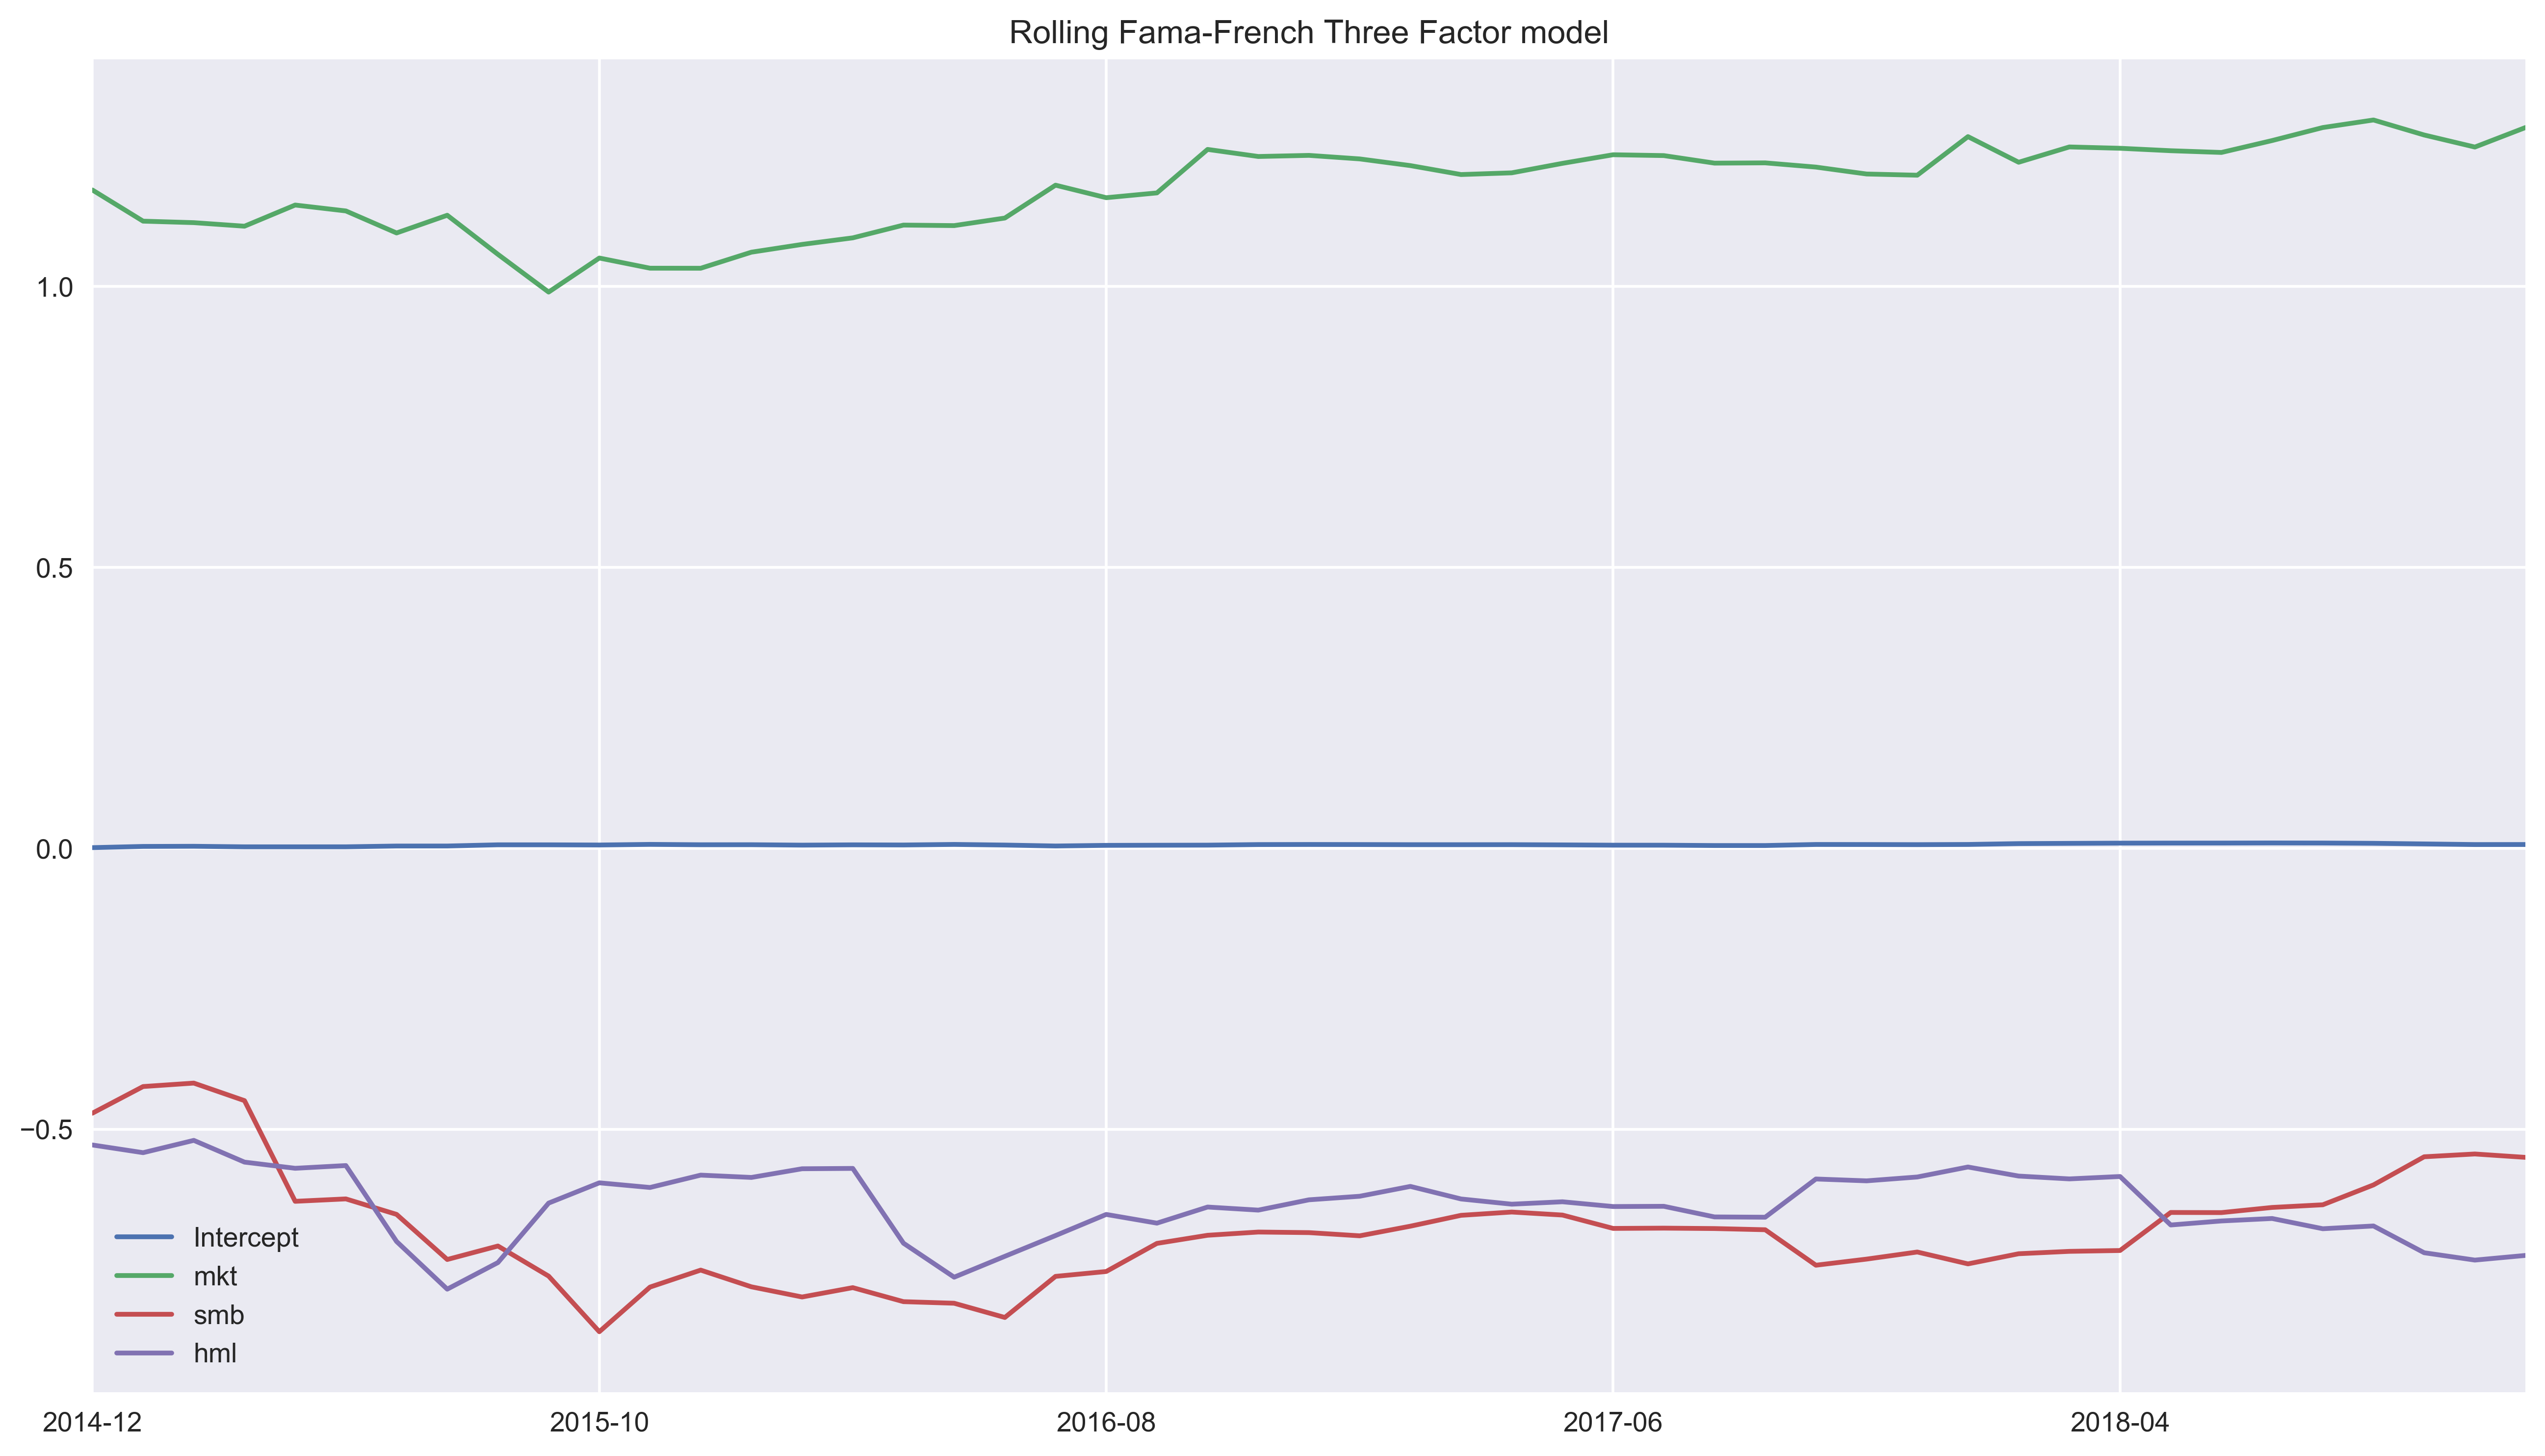

In [29]:
rolling_fama_french_df = rolling_factor_model(ff_data, 
                                              'portfolio_excess ~ mkt + smb + hml', 
                                              60)
rolling_fama_french_df.plot(title = 'Rolling Fama-French Three Factor model')

## Implementing the four- and five-factor models in Python

### How to do it...

1. Import the required libraries:

In [4]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web

In [5]:
%watermark --iversions

pandas_datareader 0.7.0
numpy             1.16.2
pandas            0.24.2
autopep8          1.4.4
json              2.0.9
yfinance          0.1.42
matplotlib        3.0.3
statsmodels       0.9.0



2. Download the risk factors from prof. French's website:

In [6]:
# three factors 
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench')[0]
df_three_factor.index = df_three_factor.index.format()

# moemntum factor
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench')[0]
df_mom.index = df_mom.index.format()

# five factors
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench')[0]
df_five_factor.index = df_five_factor.index.format()

3. Specify the risky asset and the time horizon:

In [7]:
risky_asset = 'AMZN'
start_date = '2013-12-31'
end_date = '2018-12-31'

4. Download the data of the risky asset from Yahoo Finance:

In [8]:
asset_df = yf.download(risky_asset,
                       start=start_date,
                       end=end_date,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


5. Calculate monthly returns:

In [9]:
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()
y.index = y.index.strftime('%Y-%m')
y.name = 'return'

6. Merge the datasets for the four-factor models:

In [38]:
# join all datasets on the index
four_factor_data = df_three_factor.join(df_mom).join(y)
# rename columns
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']
# divide everything except returns by 100
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] = four_factor_data.loc[:, four_factor_data.columns != 'rtn'].div(100)
# convert index to datetime
four_factor_data.index = pd.to_datetime(four_factor_data.index, format='%Y-%m')
# select period of interest
four_factor_data = four_factor_data.loc[start_date:end_date]
# calculate excess returns
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2014-01-01,-0.0332,0.0086,-0.0209,0.0,0.0172,-0.100554,-0.100554
2014-02-01,0.0465,0.0032,-0.0040,0.0,0.0208,0.009507,0.009507
2014-03-01,0.0043,-0.0189,0.0508,0.0,-0.0330,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0425,0.0114,0.0,-0.0385,-0.095847,-0.095847
2014-05-01,0.0206,-0.0185,-0.0027,0.0,0.0115,0.027686,0.027686


7. Merge the datasets for the five-factor models:

In [39]:
# join all datasets on the index
five_factor_data = df_five_factor.join(y)
# rename columns
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']
# divide everything except returns by 100
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] = five_factor_data.loc[:, five_factor_data.columns != 'rtn'].div(100)
# convert index to datetime
five_factor_data.index = pd.to_datetime(five_factor_data.index, format='%Y-%m')
# select period of interest
five_factor_data = five_factor_data.loc[start_date:end_date]
# calculate excess returns
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2014-01-01,-0.0332,0.0059,-0.0209,-0.0400,-0.0138,0.0,-0.100554,-0.100554
2014-02-01,0.0465,0.0013,-0.0040,-0.0024,-0.0044,0.0,0.009507,0.009507
2014-03-01,0.0043,-0.0117,0.0508,0.0215,0.0189,0.0,-0.071058,-0.071058
2014-04-01,-0.0019,-0.0417,0.0114,0.0351,0.0105,0.0,-0.095847,-0.095847
2014-05-01,0.0206,-0.0189,-0.0027,0.0009,-0.0106,0.0,0.027686,0.027686


8. Estimate the four-factor model:

In [41]:
# define and fit the regression model 
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', data=four_factor_data).fit()

# print results 
print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     16.81
Date:                Tue, 30 Jul 2019   Prob (F-statistic):           4.67e-09
Time:                        23:35:57   Log-Likelihood:                 86.278
No. Observations:                  60   AIC:                            -162.6
Df Residuals:                      55   BIC:                            -152.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0093      0.008      1.164      0.2

9. Estimate the five-factor model:

In [42]:
# define and fit the regression model 
five_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + rmw + cma', data=five_factor_data).fit()

# print results 
print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     15.89
Date:                Tue, 30 Jul 2019   Prob (F-statistic):           1.32e-09
Time:                        23:36:09   Log-Likelihood:                 89.462
No. Observations:                  60   AIC:                            -166.9
Df Residuals:                      54   BIC:                            -154.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.008      1.290      0.2